In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pandas as pd
from scipy.io import savemat, loadmat
import os
from tqdm import notebook
import numpy as np
from scipy import stats

from sklearn.model_selection import GridSearchCV
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from sklearn.feature_selection import RFE
from joblib import dump, load
from sklearn.decomposition import PCA

from scipy.stats import entropy
import matplotlib
from matplotlib.gridspec import GridSpec
from xgboost import cv
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle as pkl
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle as pkl
from scipy import stats

from sklearn.model_selection import cross_val_predict
import itertools
from matplotlib import rc

import shap
from shap.plots import colors
shap.initjs()


rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})

FONT_SIZE = 12

params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE,
          'pdf.fonttype': 42,
          'mathtext.fontset': 'custom',
          'mathtext.rm': 'Helvetica',
          'mathtext.it': 'Helvetica:italic',
          'mathtext.bf': 'Helvetica:bold'
         }

matplotlib.rcParams.update(params)



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Load data

Here we load the data that we prepared in MATLAB

In [2]:
version = 'v11'
window = 21
data = loadmat(f'./data/age_model_data_{window}_days_{version}.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X_all', 'd_all', 'e_all', 'g_all', 'iqr_all', 'med_all', 'n_all', 'p_all', 't_all', 'td_all', 'u_all', 'y_all'])

In [3]:
x_jid = np.squeeze(data['X_all'])
y_age = np.squeeze(data['y_all'])
x_gender = np.squeeze(data['g_all'])
x_usage = np.squeeze(data['u_all'])
x_entropy = np.squeeze(data['e_all'])
x_median = np.squeeze(data['med_all'])
x_iqr = np.squeeze(data['iqr_all'])
z_days = np.squeeze(data['d_all'])
z_total_days = np.squeeze(data['td_all'])
partIds = np.array([a[0] for a in np.squeeze(data['p_all'])])

print(x_jid.shape, len(set(partIds)))

(5235, 2500) 808


In [4]:
# Filter the samples where the JID are computed using less than 10 days, as this is usually a very noisy JID, the threshold can be changed
threshold_days = 10
idxs = z_days>= threshold_days
x_jid = x_jid[idxs]
y_age = y_age[idxs]
x_gender = x_gender[idxs]
x_median = x_median[idxs]
x_iqr = x_iqr[idxs]
x_usage = x_usage[idxs]
x_entropy = x_entropy[idxs]
# x_screen_size = x_screen_size[idxs]
partIds = partIds[idxs]
z_total_days = z_total_days[idxs]
z_days = z_days[idxs]
print(x_jid.shape)

(5093, 2500)


In [5]:
min(y_age), max(y_age)

(16.1246802093244, 87.40391738723689)

In [6]:
d = pd.DataFrame(np.concatenate([y_age[:, None], partIds[:, None]], axis=1),columns=['age','pid'])
a = d.groupby('pid').first().sort_values('age').astype('float32')
len(a)

776

array([23.1710427, 64.0399489])

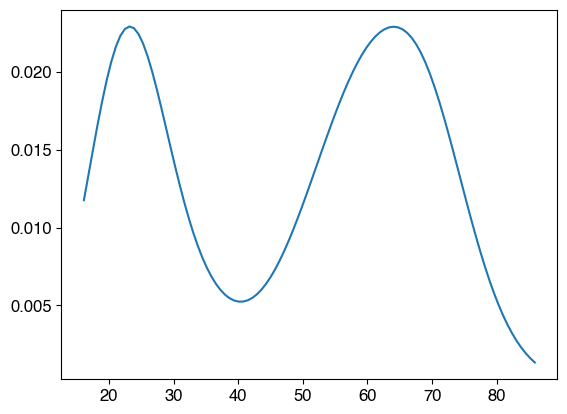

In [7]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
kernel = stats.gaussian_kde(a.age)
t = np.linspace(a.age.min(), a.age.max(), 100)
plt.plot(t, kernel(t))
pk = find_peaks(kernel(t))
t[pk[0]]

In [8]:
d = pd.DataFrame(np.concatenate([x_gender[:, None], partIds[:, None]], axis=1),columns=['gender','pid'])
a = d.groupby('pid').first().sort_values('gender').astype('float32')
len(a[a.gender == 1]), len(a[a.gender == 2]), len(a[a.gender == 999]), len(a[a.gender == 3])

(275, 490, 9, 2)

In [9]:
set(a.gender)

{1.0, 2.0, 3.0, 999.0}

In [10]:
d = pd.DataFrame(np.concatenate([z_total_days[:, None], partIds[:, None]], axis=1),columns=['tot-days','pid'])
a = d.groupby('pid').first().sort_values('tot-days').astype('float32')
len(a[a['tot-days'] >= 365])

318

In [11]:
a.max()

tot-days    1580.0
dtype: float32

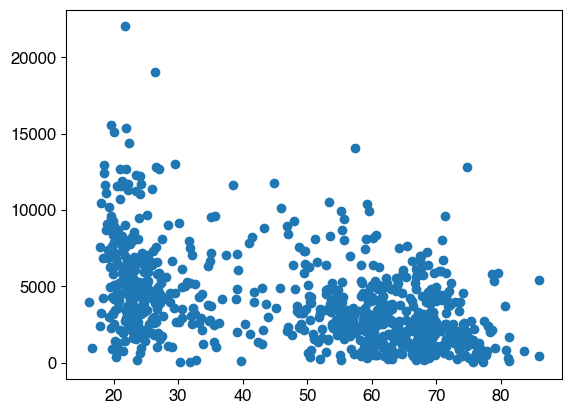

In [12]:
a = np.concatenate([y_age[:, None], x_usage[:, None], partIds[:, None]], axis=1)
a.shape
A = pd.DataFrame(a, columns=['age', 'tpd', 'pid'])

A.age = A.age.apply(lambda a: np.float32(a))
A.tpd = A.tpd.apply(lambda a: np.float32(a))
A = A.groupby('pid').mean()
A.reset_index(inplace=True)
plt.scatter(A['age'], A['tpd'])

In [ ]:
# filter age
idxs = y_age >= 40
x_jid = x_jid[idxs]
y_age = y_age[idxs]
x_gender = x_gender[idxs]
x_median = x_median[idxs]
x_iqr = x_iqr[idxs]
x_usage = x_usage[idxs]
x_entropy = x_entropy[idxs]
# x_screen_size = x_screen_size[idxs]
partIds = partIds[idxs]
z_total_days = z_total_days[idxs]
z_days = z_days[idxs]
print(x_jid.shape)

In [5]:
# create the X, Y matrices for model training
X = np.concatenate([x_jid,
                    y_age[:, None],
                    np.log10(x_iqr[:, None]),
                    np.log10(x_median[:, None]),
                    np.log10(x_usage[:, None]),
                    partIds[:, None]
                    ], axis=1)
Y = y_age
print(X.shape, Y.shape)

(5093, 2505) (5093,)


We first do some feature selection, this is not necessary all the times, but it is good practice. We want to reduce the space from 2504 features to 250 to reduce overfitting. The parameters of the simple model to do the feature selection are set in a naive way as this is not the final model.

In [ ]:
rfe = RFE(xgb.XGBRegressor(tree_method='gpu_hist'), verbose=1, step=1, n_features_to_select=250)
rfe.fit(X, Y)

In [ ]:
# Saving
pkl.dump({'support': rfe.support_}, open(f"./params/params_age_{version}.pkl", "wb"))

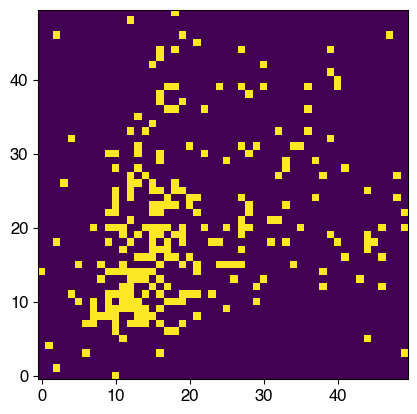

In [6]:
# Retrieving the parameters
param_dict = pkl.load(open(f"./params/params_age_20_days_v8.pkl", "rb"))

plt.imshow(param_dict['support'][:2500].reshape(50, 50))
plt.gca().invert_yaxis()

To do a proper cross validation we need to make sure samples from the same subjects do not go to both train and test.
So we first need to select the subjects for each fold and the assign the sample.

In [7]:
# to correctly reproduce train/test folds
np.random.seed(41)
n_subs = len(set(partIds))
set_partIds = np.array(list(set(partIds)))
_idx = np.random.permutation(n_subs)
permuted_partIds = set_partIds[_idx]
n_folds = 10
folds = []
idxs = np.arange(len(X))
for f in np.array_split(permuted_partIds, n_folds):
    _idxs_test = idxs[np.array([a in f for a in partIds])]
    _idxs_train = idxs[np.array([a not in f for a in partIds])]
    folds.append((_idxs_train, _idxs_test))
print(sum([sum(a) + sum(b) for a, b in folds])/ 10000)
# 12966.778 - full
# 8046.066 - old

12966.778


In [8]:
for (_a, _b) in folds:
    print(f"{len(_a)} | {len(_b)}")

4610 | 483
4641 | 452
4436 | 657
4612 | 481
4608 | 485
4571 | 522
4550 | 543
4558 | 535
4609 | 484
4642 | 451


In [15]:
feat_names = [f"{i // 50}-{i % 50}" for i in range(2500) ] + ['age', 'iqr_iti', 'median_iti', 'median_taps', 'participationId']

X = pd.DataFrame(X, columns=feat_names)
X.head()

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,49-45,49-46,49-47,49-48,49-49,age,iqr_iti,median_iti,median_taps,participationId
0,-11.502199869718812,-3.0285808478965888,-2.727550852962291,-2.426520857663154,-2.7275508529622927,-2.329610844728064,-3.0285808478965888,-2.5514595941498395,-11.502199869718812,-2.551459594149841,...,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,59.03681292781381,3.4056877866727775,2.9777236052888476,4.092158996391268,138ee6d165fa06954ba1bed56719415b12dd28eb
1,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,...,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,59.201030377807086,3.0856472882968564,2.7708520116421442,3.5949999167322457,138ee6d165fa06954ba1bed56719415b12dd28eb
2,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,...,-11.502199869718812,-2.6610355585454184,-11.502199869718812,-11.502199869718812,-11.502199869718812,59.365218290378614,3.1166077439882485,2.9116901587538613,3.7255849722706946,138ee6d165fa06954ba1bed56719415b12dd28eb
3,-11.502199869718812,-11.502199869718812,-11.502199869718812,-2.9795843355006184,-11.502199869718812,-2.979584335500617,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,...,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,59.529424037086976,3.1112625136590655,2.9036325160842376,3.9648722086377752,138ee6d165fa06954ba1bed56719415b12dd28eb
4,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,...,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,59.69390803490781,3.1878026387184195,2.965201701025912,3.7623033632877685,138ee6d165fa06954ba1bed56719415b12dd28eb


In [16]:
# This full test is used from cross validation
nbins = 50
_feat_selection = [f"{i // nbins}-{i % nbins}" for (i, v) in enumerate(param_dict['support'][:-4]) if v ] + ['iqr_iti', 'median_iti', 'median_taps']

Xdf = X[_feat_selection].astype('float32')
Ydf = X['age'].astype('float32')

dM = xgb.DMatrix(data=Xdf, label=Ydf)

_X = dM.get_data()
_y = dM.get_label()

print(_X.shape, _y.shape)

(5093, 250) (5093,)


In [18]:
params = {'objective':'reg:squarederror', 
          'tree_method': 'gpu_hist',
          'learning_rate': 0.1, 
          'max_depth': 4
          }

xgb_cv = cv(dtrain=dM, params=params, nfold = len(folds), folds=folds,
                    num_boost_round=5000, early_stopping_rounds=5, metrics=["mae", "rmse"], as_pandas=True)
n_estimators = len(xgb_cv)
xgb_cv.tail(5)

,train-mae-mean,train-mae-std,train-rmse-mean,train-rmse-std,test-mae-mean,test-mae-std,test-rmse-mean,test-rmse-std
80,3.708161,0.093949,4.869421,0.111255,6.537974,0.563343,8.741932,0.949472
81,3.690342,0.096948,4.845567,0.114647,6.533859,0.563367,8.737475,0.951064
82,3.676465,0.095621,4.828734,0.112883,6.531218,0.562238,8.734555,0.953990
83,3.656941,0.095315,4.804248,0.112269,6.528718,0.564949,8.732962,0.958170
84,3.642234,0.094278,4.784320,0.111420,6.526997,0.563423,8.730779,0.956351


In [ ]:
estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params)

cv_pred = cross_val_predict(estimator, X=_X, y=_y, cv=folds)

_rmse = pd.DataFrame(mean_squared_error(_y, cv_pred, squared=False, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_r2 = pd.DataFrame(r2_score(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_mae = pd.DataFrame(mean_absolute_error(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))

_res= pd.concat([_rmse, _r2, _mae])
_res.index = ['rmse', 'r2-score', 'mae']
_res

# GRID search of optimal parameters
Now that we have a basic model we want to otimize the parameters, as a grid search for all parameters together would be way too long to do we rely on optimizing a couple of parameters each step. For each parameter (or couple of parameters) we do a first serach and then we refine it

In [ ]:
param_test1 = {
 'max_depth':[2, 3, 4, 5, 6, 7],
 'min_child_weight': [0, 1, 2, 3, 4]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params), 
                        param_grid = param_test1, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4, 
                        cv=folds)
gsearch1.fit(X=_X, y=_y)

print(gsearch1.best_params_, gsearch1.best_score_)

best_max_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']

In [ ]:
params2 = {k: v for k,v in params.items()}
params2['max_depth'] = gsearch1.best_params_['max_depth']
params2['min_child_weight'] = gsearch1.best_params_['min_child_weight']

param_test2 = {
    'gamma': [0, 1e-1, 1e-2, 1e-3, 1e-4]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params2), 
                        param_grid = param_test2, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4, 
                        cv=folds)
gsearch2.fit(X=_X, y=_y)

print(gsearch2.best_params_, gsearch2.best_score_)
best_gamma = gsearch2.best_params_['gamma']

In [ ]:
params3 = {k: v for k,v in params2.items()}
params3['gamma'] = gsearch2.best_params_['gamma']

param_test3 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6, 11)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params3), 
                        param_grid=param_test3, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4, 
                        cv=folds
                       )

gsearch3.fit(X=_X, y=_y)
print(gsearch3.best_params_, gsearch3.best_score_)
best_colsample_bytree = gsearch3.best_params_['colsample_bytree']
best_subsample = gsearch3.best_params_['subsample']

In [ ]:
params4 = {k: v for k,v in params3.items()}
params4['colsample_bytree'] = gsearch3.best_params_['colsample_bytree']
params4['subsample'] = gsearch3.best_params_['subsample']

param_test4 = {
 'reg_alpha': [0, 1e-1, 1e-2, 1e-3, 1e-4]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params4), 
                        param_grid=param_test4, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4, 
                        cv=folds
                       )
gsearch4.fit(X=_X, y=_y)
print(gsearch4.best_params_, gsearch4.best_score_)
best_reg_alpha = gsearch4.best_params_['reg_alpha']

In [ ]:
params5 = {k: v for k,v in params4.items()}
params5['reg_alpha'] = gsearch4.best_params_['reg_alpha']

param_test5 = {
 'reg_lambda': [1, 10, 100, 1000]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params5), 
                        param_grid=param_test5, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4, 
                        cv=folds
                       )
gsearch5.fit(X=_X, y=_y)
print(gsearch5.best_params_, gsearch5.best_score_)
best_reg_lambda = gsearch5.best_params_['reg_lambda']

In [ ]:
params_final = {k: v for k,v in params5.items()}
params_final['reg_lambda'] = gsearch5.best_params_['reg_lambda']
params_final['learning_rate'] = 0.01

xgb_cv_post = cv(dtrain=dM,  params=params_final,  folds=folds,
                 num_boost_round=5000,  early_stopping_rounds=5, metrics=["rmse", "mae"], as_pandas=True)
xgb_cv_post.tail(5)

In [ ]:
estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv_post), **params_final)

cv_pred = cross_val_predict(estimator, X=_X, y=_y, cv=folds)

_rmse = pd.DataFrame(mean_squared_error(_y, cv_pred, squared=False, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_r2 = pd.DataFrame(r2_score(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_mae = pd.DataFrame(mean_absolute_error(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))

_res= pd.concat([_rmse, _r2, _mae])
_res.index = ['rmse', 'r2-score', 'mae']
_res

In [ ]:
plt.figure(figsize=(10, 5))
_idx = np.argsort(_y)
plt.plot(_y[_idx], 'o')
plt.plot(cv_pred[_idx], '.')

## Shapley full model

In [ ]:
all_shaps = []
all_inp = []

for fold_id in range(10):
    
    model_crt = xgb.XGBRegressor()
    model_crt.load_model(f'./models/model_full_age_{window}_days_{version}_fold{fold_id}.json')
    
    ## SHAP plot for loc trees
    explainer = shap.TreeExplainer(model_crt, model_output='raw') # use model_output = 1 for scale trees
    shap_values = explainer.shap_values(_X[folds[fold_id][1]])
    all_inp.append(_X[folds[fold_id][1]].todense())
    all_shaps.append(shap_values)
all_shaps = np.vstack(all_shaps)
all_inp = np.vstack(all_inp)

In [ ]:
full_shap = np.zeros((all_shaps.shape[0], 2500))
full_shap[:, param_dict['support'][:2500]] = all_shaps[:, :247]

full_inp = np.zeros((all_shaps.shape[0], 2500))
full_inp[:, param_dict['support'][:2500]] = all_inp[:, :247]

full_shap.shape, full_inp.shape

In [ ]:

MAge = full_shap

MAgeBin = np.float32(np.abs(MAge) > 0)

MAgePlus = np.zeros_like(MAge) * np.nan
MAgePlus[MAge > 0] = MAge[MAge > 0]
MAgeMinus = np.zeros_like(MAge) * np.nan
MAgeMinus[MAge < 0] = MAge[MAge < 0]

_new_prob_plus = np.zeros(2500) * np.nan
_new_prob_minus = np.zeros(2500) * np.nan
for k in range(2500):
    _x = MAgePlus[:, k]
    _new_prob_plus[k] = len(MAgeBin[:, k][_x > 0]) / len(_x) if len(MAgeBin[:, k][_x > 0]) > 0 else np.nan

    _x = MAgeMinus[:, k]    
    _new_prob_minus[k] = len(MAgeBin[:, k][_x < 0]) / len(_x)  if len(MAgeBin[:, k][_x < 0]) > 0 else np.nan

new_probs = _new_prob_plus.reshape(50,50)


In [ ]:
fig, ax = plt.subplots(1,3, figsize=(30, 30))

A = full_inp
B = full_shap
all_corr = np.array([np.corrcoef(A[:, i], B[:, i])[0,1] for i in range(2500)])

mask = np.sign(all_corr.reshape(50,50))

im = ax[0].imshow(new_probs, cmap="RdBu", vmin=0, vmax=1)
ax[0].invert_yaxis()
ax[0].set_title(f'[age] Prob on positive contribution ')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = ax[1].imshow(mask, cmap="RdBu", vmin=-1, vmax=1)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax[1].invert_yaxis()
ax[1].set_title(f'[age] contribution-value correlation mask')

im = ax[2].imshow(new_probs * mask, cmap="RdBu", vmin=-1, vmax=1)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax[2].invert_yaxis()
ax[2].set_title(f'[age] multiply')

# Simplistic model

In [10]:
# This full test is used from cross validation
# _smp_feat_selection = ['iqr_iti', 'median_iti', 'median_taps']
_smp_feat_selection = ['median_iti']

Xdf = X[_smp_feat_selection].astype('float32')
Ydf = X['age'].astype('float32')

dM = xgb.DMatrix(data=Xdf, label=Ydf)

_X = dM.get_data()
_y = dM.get_label()

print(_X.shape, _y.shape)

(5093, 1) (5093,)


In [11]:
params = {'objective':'reg:squarederror', 
          'tree_method': 'gpu_hist',
          'learning_rate': 0.1, 
          'max_depth': 4
          }

xgb_cv = cv(dtrain=dM, params=params, nfold = len(folds), folds=folds,
                    num_boost_round=5000, early_stopping_rounds=5, metrics=["mae", "rmse"], as_pandas=True)
n_estimators = len(xgb_cv)
xgb_cv.tail(5)

,train-mae-mean,train-mae-std,train-rmse-mean,train-rmse-std,test-mae-mean,test-mae-std,test-rmse-mean,test-rmse-std
43,11.286879,0.082305,14.062735,0.073641,11.657396,0.657822,14.510959,0.732536
44,11.274896,0.081698,14.058222,0.073356,11.648916,0.657487,14.510233,0.732804
45,11.264059,0.081183,14.054599,0.073315,11.639968,0.658318,14.508964,0.733693
46,11.254318,0.081340,14.050960,0.073198,11.633026,0.656641,14.507426,0.735000
47,11.245366,0.081031,14.048080,0.073197,11.626076,0.657919,14.507271,0.736434


In [12]:
estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params)

cv_pred = cross_val_predict(estimator, X=_X, y=_y, cv=folds)

_rmse = pd.DataFrame(mean_squared_error(_y, cv_pred, squared=False, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_r2 = pd.DataFrame(r2_score(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_mae = pd.DataFrame(mean_absolute_error(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_spr = pd.DataFrame(stats.spearmanr(_y, cv_pred).statistic.reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))

y_true_simple = _y
y_pred_simple = cv_pred

_res= pd.concat([_rmse, _r2, _mae, _spr])
_res.index = ['rmse', 'r2-score', 'mae', 'spearmanR']
_res

,age
rmse,14.539270
r2-score,0.271237
mae,11.618516
spearmanR,0.382015


## Supplentary figure n2

### Panel a

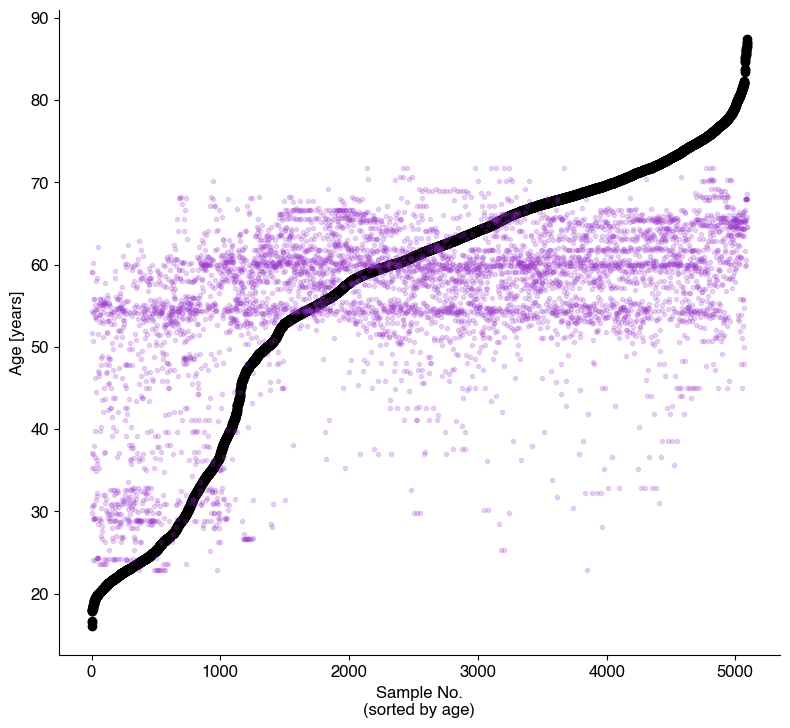

In [14]:
fig, _ax = plt.subplots(1, 1, figsize=(8, 7))
_idx = np.argsort(_y)

_ax.set_ylabel('Age [years]')

_ax.plot(_y[_idx], 'o', c='k')
_ax.plot(cv_pred[_idx], '.', c='darkorchid', alpha=0.2)

_ax.spines['right'].set_visible(False)
_ax.spines['top'].set_visible(False)
plt.tight_layout()
_ax.set_xlabel('Sample No.\n(sorted by age)')
plt.savefig('./figures/supplementary_figure_3_panel_a.pdf', transparent=True)

### Panel b
Suppl. Fig 2b: MAE violin plots tapping speed vs. full. (NEW)

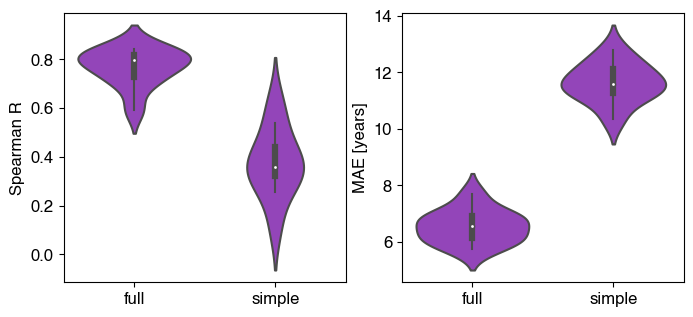

In [20]:
all_pred = []
all_true = []

all_pred_simple = []
all_true_simple = []

for fold_id, (_train, _test) in enumerate(folds):
    
    model_crt = xgb.XGBRegressor()
    model_crt.load_model(f'./models/model_full_age_{window}_days_{version}_fold{fold_id}.json')
    
    ## predictions
    pred_y = model_crt.predict(_X[_test])
    real_y = _y[_test]

    all_pred.append(pred_y)
    all_true.append(real_y)

    all_pred_simple.append(y_pred_simple[_test])
    all_true_simple.append(y_true_simple[_test])



spear_full = [stats.spearmanr(_y, _pred).statistic for _y, _pred in zip(all_true, all_pred)]
spear_simple = [stats.spearmanr(_y, _pred).statistic for _y, _pred in zip(all_true_simple, all_pred_simple)]

mae_full = [mean_absolute_error(_y, _pred) for _y, _pred in zip(all_true, all_pred)]
mae_simple = [mean_absolute_error(_y, _pred) for _y, _pred in zip(all_true_simple, all_pred_simple)]

s_c = pd.DataFrame([[x, i, 'full', 'spearman'] for i, x in enumerate(spear_full)], columns=['value', 'fold', 'metric', 'R type'])
s_s = pd.DataFrame([[x, i, 'simple', 'spearman'] for i, x in enumerate(spear_simple)], columns=['value', 'fold', 'metric', 'R type'])

r_c = pd.DataFrame([[x, i, 'full', 'MAE'] for i, x in enumerate(mae_full)], columns=['value', 'fold', 'metric', 'R type'])
r_s = pd.DataFrame([[x, i, 'simple', 'MAE'] for i, x in enumerate(mae_simple)], columns=['value', 'fold', 'metric', 'R type'])

fig, ax = plt.subplots(1,2,figsize=(8, 3.5))

a = pd.concat([s_c, s_s], axis=0)
sns.violinplot(data=a, y='value', x='metric', ax=ax[0], color='darkorchid')
ax[0].set_ylabel('Spearman R')
ax[0].set_xlabel('')

b = pd.concat([r_c, r_s], axis=0)
sns.violinplot(data=b, y='value', x='metric', ax=ax[1], color='darkorchid')
ax[1].set_ylabel('MAE [years]');
ax[1].set_xlabel('');
plt.savefig(f'./figures/supplementary_figure_3_panel_bc.pdf', transparent=True)

# Save the parameters
Technically these hypterparameters might not be ideal for all JID integration times, but we assume they are OK and we will train the models with shorter integration times (1, 2, 3, 7 days) with these parameters. If time permits one can optimize these parameters on shorter windows by using the same code.

In [ ]:
estimators = []

for i, (tr, te) in enumerate(folds):
    estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv_post), **params)
    estimator.fit(_X[tr], _y[tr])
    print(estimator.score(_X[te], _y[te]))
    estimators.append(estimator)
    estimator.save_model(f'./models/model_full_age_{window}_days_{version}_fold{i}_OLD.json')

# Load and predict full model

In [ ]:
all_pred = []
all_true = []

for fold_id, (_train, _test) in enumerate(folds):
    
    model_crt = xgb.XGBRegressor()
    model_crt.load_model(f'./models/model_full_age_{window}_days_{version}_fold{fold_id}.json')
    
    ## predictions
    pred_y = model_crt.predict(_X[_test])
    real_y = _y[_test]

    all_pred.extend(pred_y)
    all_true.extend(real_y)

all_pred = np.array(all_pred)
all_true = np.array(all_true)

pkl.dump({'all_true': all_true, 'all_pred': all_pred}, open('figure_1_panel_d.pkl', 'wb'))

_rmse = pd.DataFrame(mean_squared_error(all_true, all_pred, squared=False, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_r2 = pd.DataFrame(r2_score(all_true, all_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_mae = pd.DataFrame(mean_absolute_error(all_true, all_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_spr = pd.DataFrame(stats.spearmanr(all_true, all_pred).statistic.reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))


_res= pd.concat([_rmse, _r2, _mae, _spr])
_res.index = ['rmse', 'r2-score', 'mae', 'spearmanR']
_res

In [ ]:
stats.spearmanr(all_true[all_true >= 65], all_pred[all_true >= 65])

## Figure 1 panel D

In [ ]:
fig, _ax = plt.subplots(1,1,figsize=(12, 7.5))

_ax.set_ylabel('Age [years]')

_idx = np.argsort(all_true)
_ax.plot(all_true[_idx], 'o', c='k')
_ax.plot(all_pred[_idx], '.', c='darkorchid', alpha=0.2)

_ax.spines['right'].set_visible(False)
_ax.spines['top'].set_visible(False)

_ax.set_xlabel('Sample No.\n(sorted by age)')
plt.savefig('./figures/figure_1_panel_d.pdf', transparent=True)

# Predict OLD model

In [ ]:
all_pred = []
all_true = []

for fold_id, (_train, _test) in enumerate(folds):
    
    model_crt = xgb.XGBRegressor()
    model_crt.load_model(f'./models/model_full_age_21_days_v11_fold{fold_id}_OLD.json')
    
    ## predictions
    pred_y = model_crt.predict(_X[_test])
    real_y = _y[_test]

    all_pred.extend(pred_y)
    all_true.extend(real_y)

all_pred = np.array(all_pred)
all_true = np.array(all_true)


_rmse = pd.DataFrame(mean_squared_error(all_true, all_pred, squared=False, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_r2 = pd.DataFrame(r2_score(all_true, all_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_mae = pd.DataFrame(mean_absolute_error(all_true, all_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_spr = pd.DataFrame(stats.spearmanr(all_true, all_pred).statistic.reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))


_res= pd.concat([_rmse, _r2, _mae, _spr])
_res.index = ['rmse', 'r2-score', 'mae', 'spearmanR']
_res

## Supplementary figure n4

In [ ]:
fig, _ax = plt.subplots(1,1,figsize=(8,8))

_ax.set_ylabel('Age [years]')

_idx = np.argsort(all_true)
_ax.plot(all_true[_idx], 'o', c='k')
_ax.plot(all_pred[_idx], '.', c='darkorchid', alpha=0.2)

_ax.spines['right'].set_visible(False)
_ax.spines['top'].set_visible(False)

_ax.set_xlabel('Sample No.\n(sorted by age)')
plt.tight_layout()
plt.savefig('./figures/supplementary_figure_4.pdf', transparent=True)

# Trajectories

In [ ]:
# given a person I need to pick the model for which they were in the test fold 
def find_fold_for_partId(partId, P):
    try:
        _idx = np.where(P == partId)[0][0]
        k = np.where([_idx in a for _, a in folds])[0][0]
        return k
    except:
        return -1

In [ ]:
def find_longest_uninterrupted(times):

    if len(times.shape) == 0:
        return None
    
    beg_int = np.where(np.diff(np.float32(times < 1)) == 1)[0] + 1
    end_int = np.where(np.diff(np.float32(times < 1)) == -1)[0] + 1
    if len(beg_int) == len(end_int) + 1:
        end_int = np.array(list(end_int) + [len(m_)])
    _int_len = [ e - b for b, e in zip(beg_int, end_int) if e - b > 7]
    #     print(_int_len)
    _int = [(b, e) for b, e in zip(beg_int, end_int) if e - b > 7]
    non_int = [0] + list(itertools.chain.from_iterable(_int)) + [len(times) - 1]
    _non_int = [(a, b) for a, b in zip(non_int[::2], non_int[1::2])]
    _non_int_len = [a[1] - a[0] for a in _non_int]
    #     print(_non_int_len)
    longest = np.argmax(_non_int_len)

    if np.max(_non_int_len) >= 365:
        return _non_int[longest]
    else:
        return None

In [ ]:
all_lens = []
for i, name in notebook.tqdm(enumerate(os.listdir(f"../TrainRetrainMLAGE/evol_v11/21d/"))):
    data = loadmat(f"../TrainRetrainMLAGE/evol_v11/21d/{name}")
    X_ = np.squeeze(data['x']).T.reshape(-1, 2500)
    all_lens.append(X_.shape[0])

In [ ]:
all_ages = []
all_genders = []
all_entropy = []
the_gap = []
all_preds = []
all_preds_times = []
all_pids = []
was_testing = []
all_tests_with_times = []
for i, name in notebook.tqdm(enumerate(os.listdir(f"../TrainRetrainMLAGE/evol_v11/21d/"))):
    data = loadmat(f"../TrainRetrainMLAGE/evol_v11/21d/{name}")
    X_ = np.squeeze(data['x']).T.reshape(-1, 2500)
    a_ = np.squeeze(data['all_ages'])
    g_ = np.squeeze(data['gender'])
    u_ = np.squeeze(data['all_usage'])
    m_ = np.squeeze(data['all_median_tap_speed'])
    i_ = np.squeeze(data['all_iqr_tap_speed'])
    t_ = np.squeeze(data['all_ts'])
    nd_ = np.squeeze(data['all_n_days'])
    pid = data['partId'][0]
    
    _fold = find_fold_for_partId(pid, partIds)
    if (_fold == -1):
        continue
    
    idxs = find_longest_uninterrupted(m_)
    if idxs is None:
        continue
    
    # create the X, Y matrices for model training
    X_ = np.concatenate([np.log10(X_ + 3.1463e-12),
                        a_[:, None],
                        np.log10(i_[:, None] + 3.1463e-12),
                        np.log10(m_[:, None] + 3.1463e-12),
                        np.log10(u_[:, None] + 3.1463e-12)
                        ], axis=1)
    
    feat_names = [f"{i // 50}-{i % 50}" for i in range(2500) ] + ['age', 'iqr_iti', 'median_iti', 'median_taps']
    
    X_ = pd.DataFrame(X_[idxs[0]:idxs[1] + 1, :], columns=feat_names)
    
    nbins = 50
    _feat_selection = [f"{i // nbins}-{i % nbins}" for (i, v) in enumerate(param_dict['support'][:-4]) if v ] + ['iqr_iti', 'median_iti', 'median_taps']
    
    _x = X_[_feat_selection].astype('float32')
    _y = X_['age'].astype('float32')
    
    model_full = xgb.XGBRegressor()
    model_full.load_model(f'./models/model_full_age_21_days_v11_fold{_fold}_OLD.json')
    
    pred_over_time = model_full.predict(_x)
    
    all_preds_times.append(t_[idxs[0]:idxs[1] + 1])
    all_preds.append(pred_over_time)
    
    all_ages.append(a_[idxs[0]:idxs[1] + 1])
    all_genders.append(float(g_))
    all_pids.append(pid)

In [ ]:
savemat('all_age_pred_21d_OLD_29_12_2023.mat', {
    'all_preds': np.asanyarray(all_preds, dtype=object), 
                                                  'all_preds_times': np.asanyarray(all_preds_times, dtype=object),
                                                  'all_ages': np.asanyarray(all_ages, dtype=object), 
                                                  'all_genders': np.asanyarray(all_genders, dtype=object), 
                                                  'all_pids': np.asanyarray(all_pids, dtype=object)
                                           })

## Supplementary Figure n5  

In [ ]:
all_pids = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_pids'])
all_preds = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_preds'])
all_ages = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_ages'])
all_preds_times = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_preds_times'])

all_pids_OLD = np.squeeze(loadmat('all_age_pred_21d_OLD_29_12_2023.mat')['all_pids'])
all_preds_OLD = np.squeeze(loadmat('all_age_pred_21d_OLD_29_12_2023.mat')['all_preds'])
all_preds_times_OLD = np.squeeze(loadmat('all_age_pred_21d_OLD_29_12_2023.mat')['all_preds_times'])

In [ ]:

IDX_OLD = 15
p = all_pids_OLD[IDX_OLD][0]
IDX = np.where(np.array(all_pids) == p)[0][0]

fig, ax = plt.subplots(1,1, figsize=(9,5))

# t = pd.to_datetime(np.squeeze(all_preds_times[IDX]), unit='ms')
# ot = # pd.to_datetime(np.squeeze(all_preds_times_OLD[IDX_OLD]), unit='ms')

ax.plot(np.squeeze(all_preds[IDX]))
ax.plot(np.squeeze(all_ages[IDX]))
ax.plot(np.squeeze(all_preds_OLD[IDX_OLD]))

ax.locator_params(axis='x', nbins=4)

# ax.plot(np.squeeze(all_preds_times[IDX])[1:], np.diff(np.squeeze(all_preds[IDX])))
# ax.plot(np.squeeze(all_preds_times_OLD[IDX_OLD])[1:], np.diff(np.squeeze(all_preds_OLD[IDX_OLD])))

ax.set_xlabel('Time [days]')
ax.set_ylabel('Age [years]')

ax.set_title(rf"$\rho$ = {stats.spearmanr(np.squeeze(all_preds[IDX]), np.squeeze(all_preds_OLD[IDX_OLD])).statistic:.2f}")
# ax.set_title(stats.spearmanr(np.diff(np.squeeze(all_preds[IDX])), np.diff(np.squeeze(all_preds_OLD[IDX_OLD]))).statistic)

plt.savefig('./figures/supplementary_figure_5_a.pdf', transparent=True)

In [ ]:
plt.figure(figsize=(4,4))
old_full_spr = []
for i in range(len(all_pids_OLD)):
    p = all_pids_OLD[i][0]
    IDX = np.where(np.array(all_pids) == p)[0][0]
    old_full_spr.append(stats.spearmanr(np.squeeze(all_preds[IDX]), np.squeeze(all_preds_OLD[i])).statistic)
plt.ecdf(old_full_spr, color='darkorchid')
plt.xlabel(r'$\rho$')
plt.ylabel('Cumulative Probability')
plt.savefig('./figures/supplementary_figure_5_b.pdf', transparent=True)

In [ ]:
plt.figure(figsize=(4,4))
old_full_spr_diff = []
for i in range(len(all_pids_OLD)):
    p = all_pids_OLD[i][0]
    IDX = np.where(np.array(all_pids) == p)[0][0]
    old_full_spr_diff.append(stats.spearmanr(np.diff(np.squeeze(all_preds[IDX])), np.diff(np.squeeze(all_preds_OLD[i]))).statistic)
plt.ecdf(old_full_spr_diff, color='darkorchid')
plt.xlabel('Spearman R')
plt.savefig('./figures/supplementary_figure_4_c.pdf', transparent=True)

# Shapley trajectories

In [ ]:
all_ages = []
all_genders = []
all_entropy = []
the_gap = []
all_preds = []
all_preds_times = []
all_pids = []
was_testing = []
all_tests_with_times = []
all_shaps = []
all_inp = []

for i, name in notebook.tqdm(enumerate(os.listdir(f"../TrainRetrainMLAGE/evol_v11/21d/"))):
    # try:
        data = loadmat(f"../TrainRetrainMLAGE/evol_v11/21d/{name}")
    
        X_ = np.squeeze(data['x']).T.reshape(-1, 2500)
        a_ = np.squeeze(data['all_ages'])
        g_ = np.squeeze(data['gender'])
        u_ = np.squeeze(data['all_usage'])
        m_ = np.squeeze(data['all_median_tap_speed'])
        i_ = np.squeeze(data['all_iqr_tap_speed'])
        t_ = np.squeeze(data['all_ts'])
        nd_ = np.squeeze(data['all_n_days'])
        pid = data['partId'][0]
        
        _fold = find_fold_for_partId(pid, partIds)
        print(_fold)
        if (_fold == -1):
            continue
        
        idxs = find_longest_uninterrupted(m_)
        if idxs is None:
            continue

        # create the X, Y matrices for model training
        X_ = np.concatenate([np.log10(X_ + 3.1463e-12),
                            a_[:, None],
                            np.log10(i_[:, None] + 3.1463e-12),
                            np.log10(m_[:, None] + 3.1463e-12),
                            np.log10(u_[:, None] + 3.1463e-12)
                            ], axis=1)
        
        feat_names = [f"{i // 50}-{i % 50}" for i in range(2500) ] + ['age', 'iqr_iti', 'median_iti', 'median_taps']
        
        X_ = pd.DataFrame(X_, columns=feat_names)
        
        nbins = 50
        _feat_selection = [f"{i // nbins}-{i % nbins}" for (i, v) in enumerate(param_dict['support'][:-4]) if v ] + ['iqr_iti', 'median_iti', 'median_taps']
        
        _x = X_[_feat_selection].astype('float32')
        _y = X_['age'].astype('float32')
        
        model_full = xgb.XGBRegressor()
        model_full.load_model(f'./models/model_full_age_21_days_v11_fold{_fold}.json')
        
        explainer = shap.TreeExplainer(model_full, model_output='raw') # use model_output = 1 for scale trees
        shap_values = explainer.shap_values(_x)
        all_shaps.append(shap_values)
        all_inp.append(X_.astype('float32'))

        pred_over_time = model_full.predict(_x)
        
        all_preds_times.append(t_)
        all_preds.append(pred_over_time)
        
        all_ages.append(a_)
        all_genders.append(float(g_))
        all_pids.append(pid)

    # except:
        # print(f"{name[0]} not FOUND or could not process")
        # continue


In [ ]:
def plot_JID(JID, ax, mask=None, color_bar_text="PD", cmap=matplotlib.cm.RdGy_r, vmin=None, vmax=None):
    labels = ['0.1', '1', '4', '20']
    ticks = np.arange(50)[::10][1:]
    im = ax.imshow(JID, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

    cmap.set_bad('white',1.)
    
    if mask is not None:
        ax.imshow(mask, 'gray_r', interpolation='none', alpha=0.2, vmin=vmin, vmax=vmax)
    ax.invert_yaxis()
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    ax.set_ylabel(r'$ITI(k + 1)$ [s]')
    ax.set_xlabel(r'$ITI(k)$ [s]')
    ax.text(-9, 50.5, color_bar_text)
    ax.grid(False)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    
def find_closest(x, a):
    return np.argmin(np.abs(x - a)) + 1

## Figure 1 panel e

In [ ]:
# good samples 14, 19, 25, 126
IDX = np.where(np.array(all_pids) == '138eb833b8fd25944a228eb31a67909eace928eb')[0][0]
idxs = [80, 234, 400, 600, 790]
fig = plt.figure(figsize=(31, 19.5), tight_layout=True)
gs = gridspec.GridSpec(3, len(idxs))

pkl.dump({'preds': all_preds[IDX], 'ages': all_ages[IDX], 'inp': all_inp[IDX]}, open(f"figure_1_panel_e.pkl", "wb"))

# taps
axt = fig.add_subplot(gs[:2, :])
axt.plot(all_preds[IDX], label='Behavioural Age', color='darkorchid')
axt.plot(all_ages[IDX], label='Chronological Age', color='orange')
for i, _idx in enumerate(idxs) :
    axt.plot([_idx, _idx], [np.min(all_preds[IDX]) - 2, np.max(all_preds[IDX]) + 2], '--k')
    
    # taps
    jd1b = fig.add_subplot(gs[2, i])
    full_inp = all_inp[IDX].values[_idx, :2500]

    plot_JID(10 ** full_inp.reshape(50, 50), jd1b)
axt.set_xlabel('Duration [days]')
axt.set_ylabel('Age [years]')
axt.spines['right'].set_visible(False)
axt.spines['top'].set_visible(False)
axt.legend(
    loc="lower left", # "upper center" puts it below the line
    ncol=2,
    # bbox_to_anchor=(0.5, 1.0),
    # bbox_transform=fig.transFigure 
);
axt.set_xlim([0, len(all_preds[IDX]) - 1])
axt.set_ylim([min(all_preds[IDX]) - 2, max(all_preds[IDX]) + 2])
plt.tight_layout()
plt.savefig('./figures/figure_1_panel_e.pdf', transparent=True)

## Buckets

In [ ]:
all_bucktes = np.squeeze(np.array(loadmat('../ML_Age_Trajectory_2023/all_buckets.mat')['all_buckets']))
pids_for_buckets = np.squeeze(np.array(loadmat('../ML_Age_Trajectory_2023/all_buckets.mat')['pids_for_buckets']))
all_dom = np.squeeze(np.array(loadmat('../ML_Age_Trajectory_2023/all_buckets.mat')['all_dom']))
all_y = np.squeeze(np.array(loadmat('../ML_Age_Trajectory_2023/all_buckets.mat')['all_y']))

In [ ]:
rel_idx = 70
IDX = np.where(np.array(all_pids) == pids_for_buckets[rel_idx][0])[0][0]

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

ax[0][0].plot(all_preds_times[IDX], all_preds[IDX])

bucketL = all_bucktes[rel_idx][0][0]
bucketR = all_bucktes[rel_idx][1][0]

ax[0][0].plot(all_preds_times[IDX][[0, -1]], [bucketL] * 2, '--r')
ax[0][0].plot(all_preds_times[IDX][[0, -1]], [bucketR] * 2, '--g')
ax[0][1].plot(np.squeeze(all_y[rel_idx]), np.squeeze(all_dom[rel_idx]))

_x = all_preds[IDX]
# _idxs = np.where((_x >= bucketL[0]) & ((_x <= bucketL[1])))[0]
_idxs = np.where(((_x <= bucketL[1])))[0]
full_shap = np.zeros((len(_idxs), 2500)) * np.nan
full_shap[:, param_dict['support'][:2500]] = all_shaps[IDX][_idxs, :247]
plot_JID(full_shap.mean(0).reshape(50, 50), ax[1][0], cmap=colors.red_blue,)

_idxs = np.where((_x >= bucketR[0]) & ((_x <= bucketR[1])))[0]
full_shap = np.zeros((len(_idxs), 2500)) * np.nan
full_shap[:, param_dict['support'][:2500]] = all_shaps[IDX][_idxs, :247]
plot_JID(full_shap.mean(0).reshape(50, 50), ax[1][1], cmap=colors.red_blue)


_x = all_preds[IDX]
_idxs = np.where(((_x <= bucketL[1])))[0]
full_shapL = np.zeros((len(_idxs), 2500)) * np.nan
full_shapL[:, param_dict['support'][:2500]] = all_shaps[IDX][_idxs, :247]

_idxs = np.where((_x >= bucketR[0]) & ((_x <= bucketR[1])))[0]
full_shapR = np.zeros((len(_idxs), 2500)) * np.nan
full_shapR[:, param_dict['support'][:2500]] = all_shaps[IDX][_idxs, :247]
plot_JID(np.sign(-full_shapL.mean(0).reshape(50, 50) + full_shapR.mean(0).reshape(50, 50)), ax[1][2], cmap=colors.red_blue)
# now shapley

# now shapley

In [ ]:
# old vs younger states
# 1: identify a younger state and an older state
# 2: pull shapley values for the predictions falling into younger or older states
# 3: extract multiply plot for each state (for the example):
# 3a: Find proportion of days in which a pixel contributed positively or negatively
# 3b: Find correlation for each pixel (either direct or inverse proportion)
# 3c: multiply
# 
# At the population level
# 4: extract difference of shapley for each state (obtained in 2)
# 4a: average the shapley across the state
# 4b: older - younger >> positive means pixel drives the predicted age (relatively) up more than the pixel does in the younger state.
# 4c: take the sign of the difference (4b)
# 4d: repeat for all population (with 2 stable states)
# 4e: look at the proportion of people contributing positively at a given pixel
# 4f: find correlation between pixel value and pixel contribtuion across the population 
# 4g: multiply and admire >> 2 plots in 1 such that one plot corresponds to direct or inverse proportion 

all_2states_inp = []
all_2states_shap = []
all_2states_shap_diff = []

# 4d
for rel_idx in range(len(pids_for_buckets)):
    IDX = np.where(np.array(all_pids) == pids_for_buckets[rel_idx][0])[0][0]
    
    bucketL = all_bucktes[rel_idx][0][0]
    bucketR = all_bucktes[rel_idx][1][0]

    _full_shap = np.zeros((all_shaps[IDX].shape[0], 2500)) * np.nan
    _full_shap[:, param_dict['support'][:2500]] = all_shaps[IDX][:, :247]
    all_2states_shap.append(_full_shap.reshape(-1, 50, 50))

    _full_shap = np.zeros((all_inp[IDX].shape[0], 2500)) * np.nan
    _full_shap[:, param_dict['support'][:2500]] = all_inp[IDX].values[:, :247]
    all_2states_inp.append(_full_shap.reshape(-1, 50, 50))
    
    _x = all_preds[IDX]
    _idxs = np.where((_x >= bucketL[0]) & ((_x <= bucketL[1])))[0]
    full_shapL = np.zeros((len(_idxs), 2500)) * np.nan
    full_shapL[:, param_dict['support'][:2500]] = all_shaps[IDX][_idxs, :247]
    
    _idxs = np.where((_x >= bucketR[0]) & ((_x <= bucketR[1])))[0]
    full_shapR = np.zeros((len(_idxs), 2500)) * np.nan
    full_shapR[:, param_dict['support'][:2500]] = all_shaps[IDX][_idxs, :247]

    # 4a
    full_shapL_mean = full_shapL.mean(0).reshape(50, 50)
    full_shapR_mean = full_shapR.mean(0).reshape(50, 50)

    # 4b
    all_2states_shap_diff.append(full_shapR_mean - full_shapL_mean)


# 4e
all_2states_shap_diff = np.stack(all_2states_shap_diff)
all_2states_prop = np.zeros((50,50)) * np.nan
for i in range(50):
    for j in range(50):
        n = len(all_2states_shap_diff[~np.isnan(all_2states_shap_diff[:, i, j]), i, j])
        all_2states_prop[i, j] = np.mean(all_2states_shap_diff[:, i, j] > 0) if n > 0 else np.nan

# 4f
vstack_shap = np.vstack(all_2states_shap)
vstack_inp = np.vstack(all_2states_inp)
vstack_shap.shape, vstack_inp.shape

all_2states_corr = np.zeros((50,50)) * np.nan
for i in range(50):
    for j in range(50):
        all_2states_corr[i, j] = np.corrcoef(vstack_inp[:, i, j], vstack_shap[:, i, j])[0,1]

### Figure 4 panel b

In [ ]:
FONT_SIZE = 12

params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE,
         }
matplotlib.rcParams.update(params)

fig, ax0 = plt.subplots(1, 1, figsize=(6, 6.3))

plot_JID(all_2states_prop, ax0, cmap=matplotlib.cm.Greys, vmin=0.3, vmax=0.8)
ax0.set_title('Proportion positive difference', y=1.2)

plt.savefig('./figures/figure_4_panel_b_1.pdf', transparent=True)

In [ ]:
FONT_SIZE = 24

params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE,
         }
matplotlib.rcParams.update(params)

fig, ax1 = plt.subplots(1,1,figsize=(5, 5.2))

M = all_2states_prop * np.sign(all_2states_corr)
Mp = np.zeros_like(M)
Mm = np.zeros_like(M)
Mp[:] = M[:]
Mm[:] = M[:]
Mp[Mp < 0] = np.nan
Mm[Mm > 0] = np.nan

plot_JID(np.abs(Mp), ax1, cmap=matplotlib.cm.Reds, vmin=0.3, vmax=0.8)
ax1.set_title('Directly prop', y=1.3)

plt.savefig('./figures/figure_4_panel_b_2.pdf', transparent=True)

In [ ]:
fig, ax2 = plt.subplots(figsize=(5, 5.2))
FONT_SIZE = 24

params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE,
         }
matplotlib.rcParams.update(params)


M = all_2states_prop * np.sign(all_2states_corr)
Mp = np.zeros_like(M)
Mm = np.zeros_like(M)
Mp[:] = M[:]
Mm[:] = M[:]
Mp[Mp < 0] = np.nan
Mm[Mm > 0] = np.nan

plot_JID(np.abs(Mm), ax2, cmap=matplotlib.cm.Purples, vmin=0.3, vmax=0.8)

ax2.set_title('Inverse prop', y=1.3)

plt.savefig('./figures/figure_4_panel_b_3.pdf', transparent=True)

## Supplementary figure 8

In [ ]:
all_stack_shap = np.vstack(all_shaps)

full_shap = np.zeros((all_stack_shap.shape[0], 2500)) * np.nan
full_shap[:, param_dict['support'][:2500]] = all_stack_shap[:, :247]
full_shap = full_shap.reshape(-1, 50, 50)

all_stack_inp = np.vstack(all_inp)

full_inp = np.zeros((all_stack_inp.shape[0], 2500)) * np.nan
full_inp[:, :] = all_stack_inp[:, :2500]
full_inp = full_inp.reshape(-1, 50, 50)

In [ ]:
# 4e
all_prop = np.zeros((50,50)) * np.nan
for i in range(50):
    for j in range(50):
        n = len(full_shap[~np.isnan(full_shap[:, i, j]), i, j])
        all_prop[i, j] = np.mean(full_shap[:, i, j] > 0) if n > 0 else np.nan

In [ ]:
# 4f
all_corr = np.zeros((50,50)) * np.nan
for i in range(50):
    for j in range(50):
        all_corr[i, j] = np.corrcoef(full_inp[:, i, j], full_shap[:, i, j])[0,1]

In [ ]:
FONT_SIZE = 12

params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE,
         }
matplotlib.rcParams.update(params)

fig, ax0 = plt.subplots(1, 1, figsize=(6, 6.3))

plot_JID(all_prop, ax0, cmap=matplotlib.cm.Greys, vmin=0.3, vmax=0.8)
ax0.set_title('Proportion positive difference', y=1.2)

plt.savefig('./figures/supplementary_figure_8_panel_a.pdf', transparent=True)

In [ ]:
FONT_SIZE = 24

params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE,
         }
matplotlib.rcParams.update(params)

fig, ax1 = plt.subplots(1,1,figsize=(5, 5.2))

M = all_prop * np.sign(all_corr)
Mp = np.zeros_like(M)
Mm = np.zeros_like(M)
Mp[:] = M[:]
Mm[:] = M[:]
Mp[Mp < 0] = np.nan
Mm[Mm > 0] = np.nan

plot_JID(np.abs(Mp), ax1, cmap=matplotlib.cm.Reds, vmin=0.3, vmax=0.8)
ax1.set_title('Directly prop', y=1.3)

plt.savefig('./figures/supplementary_figure_8_panel_b.pdf', transparent=True)

In [ ]:
fig, ax2 = plt.subplots(figsize=(5, 5.2))
FONT_SIZE = 24

params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE,
         }
matplotlib.rcParams.update(params)

M = all_prop * np.sign(all_corr)
Mp = np.zeros_like(M)
Mm = np.zeros_like(M)
Mp[:] = M[:]
Mm[:] = M[:]
Mp[Mp < 0] = np.nan
Mm[Mm > 0] = np.nan

plot_JID(np.abs(Mm), ax2, cmap=matplotlib.cm.Purples, vmin=0.3, vmax=0.8)

ax2.set_title('Inverse prop', y=1.3)

plt.savefig('./figures/supplementary_figure_8_panel_c.pdf', transparent=True)

In [ ]:
FONT_SIZE = 12

params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE,
         }

fig = plt.figure(figsize=(8, 8), tight_layout=True)
gs = gridspec.GridSpec(2, 3)

# taps
ax0 = fig.add_subplot(gs[:, :2])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[1, 2])

plot_JID(all_prop, ax0, cmap=matplotlib.cm.Greys, vmin=0.3, vmax=0.8)

ax0.set_title('Proportion positive difference', y=1.2)

M = all_prop * np.sign(all_corr)
Mp = np.zeros_like(M)
Mm = np.zeros_like(M)
Mp[:] = M[:]
Mm[:] = M[:]
Mp[Mp < 0] = np.nan
Mm[Mm > 0] = np.nan

plot_JID(np.abs(Mp), ax1, cmap=matplotlib.cm.Reds, vmin=0.3, vmax=0.8)

ax1.set_title('Directly prop', y=1.2)

plot_JID(np.abs(Mm), ax2, cmap=matplotlib.cm.Purples, vmin=0.3, vmax=0.8)
# im = ax[2].imshow(np.abs(Mm), cmap='Blues', vmin=0.3, vmax=0.8)
# ax[2].invert_yaxis()
# divider = make_axes_locatable(ax[2])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax)

ax2.set_title('Inverse prop', y=1.2)

plt.tight_layout()
plt.savefig('./figures/supplementary_figure_8.pdf', transparent=True)

# Stable points

In [22]:
spoints = np.squeeze(loadmat('../ML_Age_Trajectory_2023/all_stable_points_20_12_2023.mat')['all_stable_points'][0])
sages = np.squeeze(loadmat('../ML_Age_Trajectory_2023/all_stable_points_20_12_2023.mat')['sorted_ages'])
mus = np.squeeze(loadmat('../ML_Age_Trajectory_2023/all_stable_points_20_12_2023.mat')['all_MU'])
sigma = np.squeeze(loadmat('../ML_Age_Trajectory_2023/all_stable_points_20_12_2023.mat')['all_SIGMA'])

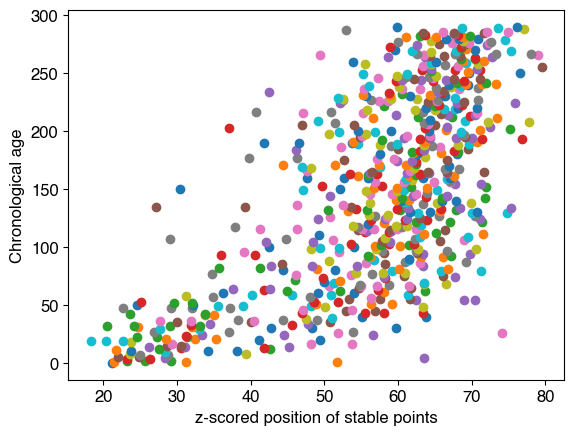

In [23]:
fig, ax = plt.subplots(1,1)
all_x, all_y, all_a = np.zeros((len(sages), 6)), np.zeros((len(sages), 6)), np.zeros((len(sages), 6))
for i, (a, ps) in enumerate(zip(sages, spoints)):
    _ax = np.zeros(6) * np.nan
    _ay = np.zeros(6) * np.nan
    _aa = np.zeros(6) * np.nan
    # print(i)
    xs = []
    for j, _x in enumerate(ps[0]):
        if len(_x) > 0:
            _ax[j] = _x[0][0][0] * sigma[i] + mus[i]
            _ay[j] = i
            _aa[j] = a
            xs.append(_x[0][0][0])
    all_x[i, :] = _ax
    all_y[i, :] = _ay
    all_a[i, :] = _aa
    ax.scatter(np.array(xs) * sigma[i] + mus[i], [i] * len(xs))
    # ax.scatter(np.array(xs), [a] * len(xs))
ax.set_ylabel('Chronological age')
ax.set_xlabel('z-scored position of stable points');

<Axes: ylabel='Count'>

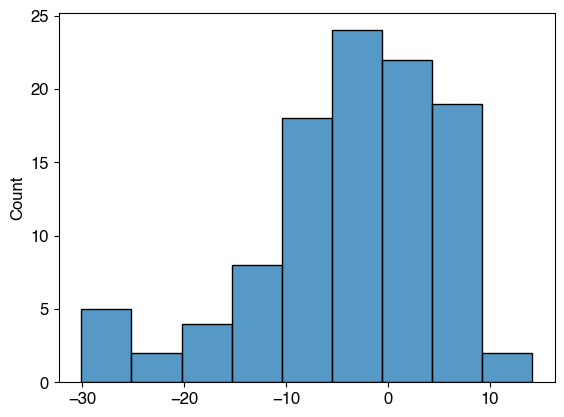

In [103]:
sns.histplot(sages - all_x[:, 2])

## Figure 2 panel B

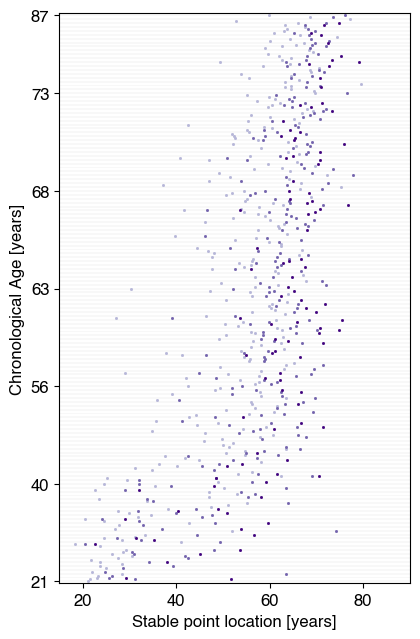

In [171]:
import matplotlib

c1 = matplotlib.colormaps['Purples']

fig, ax = plt.subplots(1,1, figsize=(4.3, 6.5))

ax.plot(all_x[:, 0], all_y[:, 0], 's', color=c1(0.4), markersize=1)
ax.plot(all_x[:, 1], all_y[:, 1], 's', color=c1(0.7), markersize=1)
ax.plot(all_x[:, 2], all_y[:, 2], 's', color=c1(0.99), markersize=1)
for i in range(300):
    if (i % 2) == 0:
        ax.fill_between([10, 90], [i-0.5, i-0.5], [i+0.5, i+0.5], color='grey', alpha=0.05,linewidth=0)
ax.set_yticks([0, 50, 100, 150, 200, 250, 290])
ax.set_yticklabels(np.int32(sages[[0, 50, 100, 150, 200, 250, 290]]));
ax.set_ylim([-1, 291])
ax.set_xlim([15, 90])
ax.set_xlabel('Stable point location [years]')
ax.set_ylabel('Chronological Age [years]')
plt.tight_layout()
plt.savefig('./figures/figure_2_panel_b.pdf', transparent=True)

In [131]:
y_bin_size = 5
x_bin_size = 5

y_bins = np.arange(start=20, stop=85, step=y_bin_size)
x_bins = np.arange(start=20, stop=85, step=x_bin_size)

In [132]:
A = np.zeros((len(x_bins) - 1, len(y_bins) - 1))
B = np.zeros(len(y_bins) - 1)
for i in range(len(y_bins) - 1):
    _x = all_x[:, 0]
    _xbin0 = _x[(sages >= y_bins[i]) & (sages < y_bins[i + 1])]
    _x = all_x[:, 1]
    _xbin1 = _x[(sages >= y_bins[i]) & (sages < y_bins[i + 1])]
    _x = all_x[:, 2]
    _xbin2 = _x[(sages >= y_bins[i]) & (sages < y_bins[i + 1])]
    B[i] = len(_xbin0)
    _hist = np.histogram(np.concatenate([_xbin0, _xbin1, _xbin2]), bins=x_bins, density=True)
    A[:, i] = _hist[0]

In [190]:
A = all_x[(sages >= 40) & (sages <= 45), :]

In [193]:
A

array([[24.58841794, 32.11738146,         nan,         nan,         nan,
                nan],
       [48.89545183, 56.26030111, 59.16663726,         nan,         nan,
                nan],
       [29.53838516, 32.09171389,         nan,         nan,         nan,
                nan],
       [25.17128118, 48.62657058, 48.62657058, 51.90386794,         nan,
                nan],
       [62.42626879, 68.95749283, 70.48118438,         nan,         nan,
                nan]])

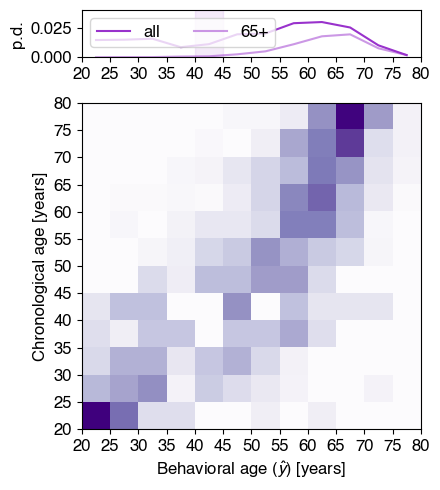

In [187]:
fig = plt.figure(figsize=(4.5, 5))
gs = gridspec.GridSpec(5, 1)

# taps
axt = fig.add_subplot(gs[0, 0])
axi = fig.add_subplot(gs[1:, 0], sharex=axt)
# axf = fig.add_subplot(gs[1:, -1], sharey=axi)
# axf.plot(A.sum(0), np.)
# axf.invert_axis()

axi.imshow(A.T, aspect='auto', cmap='Purples')
axi.invert_yaxis()
axt.plot(A.sum(1) / 12, label='all', color='darkorchid')
axt.plot(A[:, -4:].sum(1) / 12, label='65+',  color='darkorchid', alpha=0.5)
axt.set_ylabel('p.d.')
_m = A[:, :].sum(1).max() / 12
axt.fill_between([3.5,4.5], [-0.0,-0.0], [0.04, 0.04], alpha=0.1,  color='darkorchid')
axt.set_ylim([-0.0, 0.04])
axt.legend(ncols=2)
axi.set_xticks(np.arange(len(x_bins))[::]-0.5)
axi.set_yticks(np.arange(len(y_bins))[::]-0.5)
axi.set_xticklabels(np.int32(x_bins[::]))
axi.set_yticklabels(np.int32(y_bins[::]))
axi.set_xlabel(r'Behavioral age ($\hat{y}$) [years]')
axi.set_ylabel('Chronological age [years]')
# plt.subplots_adjust(hspace=0.0)
plt.tight_layout()

plt.savefig('./figures/figure_x1_review.pdf', transparent=True)

In [135]:
y_bins[4:6]

array([40, 45])

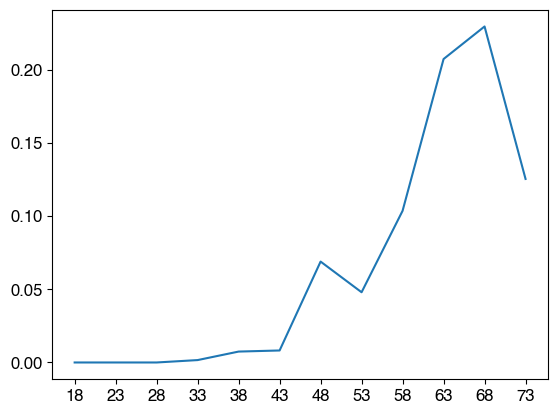

In [116]:
fig, axi = plt.subplots(1,1)
axi.plot(A[:, -4:].sum(1))
axi.set_xticks(np.arange(len(x_bins))[:-1:])
# axi.set_yticks(np.arange(len(y_bins))[-4:])
axi.set_xticklabels(np.int32(x_bins[:-1:]));
# axi.set_yticklabels(np.int32(y_bins[-4:]))


## Supplementary figure n6

### Panel a

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7.5,7.5))
ax.hist(sages, bins=np.linspace(20, 80, 20), linewidth=5, density=True, color='darkorchid', alpha=0.3)
ax.set_xlabel('Chronological age [years]')
plt.savefig('./figures/supplementary_figure_5_panel_a.pdf', transparent=True)

### Panels b-c

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1,2,figsize=(9, 5), sharey=True)
a = all_x[:, :3].astype('int32').reshape(-1)
b = all_a[:, :3].astype('int32').reshape(-1)
ax[0].hist(sages, bins=np.linspace(20, 80, 20), alpha=0.3, color='darkorchid', density=True, histtype=u'step', label = 'Chronological Age', linewidth=3,)
ax[0].hist(a[a > 0], bins=np.linspace(20, 80, 20), alpha=0.3, density=True)
ax[0].legend()
ax[1].hist(sages, bins=np.linspace(20, 80, 20), alpha=0.3, linewidth=3, histtype=u'step', label = 'Chronological Age', density=True, color='darkorchid')
ax[1].hist(a[(a > 0) & (b >= 65)], bins=np.linspace(20, 80, 20), linewidth=5, color='r', density=True, alpha=0.3)
ax[1].legend()
ax[0].set_xlabel(r'Stable point location [Behavioral age, $\hat{y}^*$]')
ax[0].set_ylabel('Probability Density')
ax[1].set_xlabel(r'Stable point location [Behavioral age, $\hat{y}^*$]')
ax[0].set_title('Full population')
ax[1].set_title('>= 65 years old')
plt.savefig('./figures/supplementary_figure_6_panel_bc.pdf', transparent=True)

# Figure 4

In [ ]:
# good samples 14, 19, 25
IDX = 126
idxs = [264, 482, 758]
fig = plt.figure(figsize=(15, 20), tight_layout=True)
gs = gridspec.GridSpec(4, len(idxs))

# taps
axt = fig.add_subplot(gs[0, :])
axt.plot(all_preds[IDX])
axt.plot(all_ages[IDX])

# Public ID

In [25]:
import pandas as pd
import numpy as np
from scipy.io import loadmat, savemat
publicID = pd.read_csv('../TrainRetrainMLAGE/public_ids_age_studies.csv')
publicID

,partId,publicId
0,138eecd2d8d7f1ee41168d764ca453383bdc28eb,fbf706c04a1b6db33177404dd536746089db1152cf0dca...
1,138eff9ed9d0ca5148338d065663ea416a6328eb,d1010d9f082d7ba2eb8e9e329004dcceadf0e1d40c3942...
2,138effa54051559344629ad845d145621b4e28eb,3c210b4661b6db2f889861fdd2c952ea2521fea304c782...
3,138efcf1e85b889f4bd3ac37c83bc874e87628eb,eb2f5727e456439b0d478269517896923c8adb90dc8d95...
4,138ef63ca45be733449bb9e0d55b73ebbea028eb,8967ce127fbe46f3113b71e163b1f3ed333e621642fa1f...
...,...,...
907,138ed874b188023e480ab7349d59064987ff28eb,af6804d41cb62bc2645ceae7cfa8feef0c3231e5c720b4...
908,138e3a378c5053ce4bc5858a469e00991a1a28eb,749c2053724d367728070bed2e75db341701a81c41b64e...
909,138ec99402ec7fe5490cb1f43795e3b5e60228eb,cbbd62305fd746f8b2e3c052443dffe59fcdc57599823c...
910,138ef90823caf51f4250884d79253cec338e28eb,85c7ac2129e5ca8eab5e3167e24f3630bbe0f5316fffb3...


In [34]:
D = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_pids'])
equivalent = [ publicID[publicID.partId == a[0]].publicId.iloc[0] for a in D]

In [35]:
savemat('publiID_age_trajectory.mat', {'all_pub': np.asanyarray(equivalent, dtype=object)})


In [36]:
equivalent

['e39a5d60d7e884e4b638d442fdcc1e571336064317f04692206d071b651aba50bfd1550334f06d6acc8a8c68768540503dfeb3cc72d643ffa65b38474e3af615',
 '7cc139c2c317985844f2cbbe179c5430faa1278b8d773f56978e22ef9e9099cb68dc4ffe71ff41f58718e9f8a097979ad6a588f167af7f466c9f03c9d6f225e3',
 'dbb6572da6499465cc448f43fc600e0308eb8d46fe729d4285a74df09430deb20092b782f905c29fea7a635b532d06e2f6639f98e4a29c7c0fa4c90a7670500c',
 'a654834d64e89b82b349cc3db636382b2799ca17b2e37f7cd7623abe2704b145bc478da948c0b6aaf95acc959b89f54c6fa5558b634626bb5989379a0051d603',
 'a354e7129fcc8c90dfb64b41d310c64359ca92c25a94bef482ef64a5d83cf000661b8ccaff33e54b91803e2944dc42fbad4ec2e864140fb4f2e30f62220dd854',
 '93f5cf78c3e98bd479929c3739d6519c8942756fffc915f4145f82f7bb05878718a065facebe8be68da78e637fd919fc2c4a6e4ee5d3c91a1fd599a3d6fffdc5',
 'ef1b92117ebf70423bdb3cb861c7430d26bd7797c22435bb52f499e30baa5f9061a0079766d076af3679a0792d6041e110de92b2fa5d74bb76510e62b150735b',
 'c887309b4fba278362e902f59bb0d8ed847b046e040d9e5489241ce9ca942d07140